In [1]:
import numpy as np
import pywt
import pywt.data
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os 
from PIL import Image
Image.MAX_IMAGE_PIXELS = 900_000_000
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
from collections import Counter
import zipfile 
import urllib.request
import random
import functools as fct
import math as mt
import rasterio
import rasterio.features
import rasterio.warp

In [7]:
# ACQUIRE COUNTRY-WIDE POPULATION-DENSITY MAP. 
# Our procedure comes from StackOverflow:
#         https://discuss.analyticsvidhya.com/t/how-to-read-zip-file-directly-in-python/1659
# 
urllib.request.urlretrieve('https://data.humdata.org/dataset/cbfc4206-35c8-42d4-a096-b2dd0aec983d/resource/1b7e9361-651a-4bf2-839b-eaf5c5f45ec1/download/population_zaf_2018-10-01.csv.zip',
                           'sa_pop.zip')
sa_pop_zip = zipfile.ZipFile('sa_pop.zip')
sa_pop_csv = pd.read_csv(filepath_or_buffer = sa_pop_zip.open('population_zaf_2018-10-01.csv'))

In [8]:
# Read in image layer — a bitmap image exported from Google Maps and georeferenced in QGIS.
dataset = rasterio.open('./200216 J-Berg O-head Image_modified.tif')


In [63]:
𝗔 = np.reshape(a = np.array(dataset.transform[:6]),
               newshape = (2,3))[:,:2]
𝗯 = np.expand_dims(a = np.reshape(a = np.array(dataset.transform[:6]),
                                  newshape = (2,3))[:,-1],
                   axis = -1)

In [79]:
dataset.transform

Affine(4.429449537121801e-05, 0.0, 27.95229970011734,
       0.0, -4.429449537121801e-05, -26.06212510992952)

In [ ]:
# We need a function to convert lat, long into pixel location. 

In [194]:
dataset.height * dataset.width

11045250

In [151]:
𝘓_ticks_labels = [round(tick_lab, 4)
                      for tick_lab in np.arange(start = 27.975,
                                               stop = 28.17,
                                               step = 0.025)]
𝜆_ticks_labels = [round(tick_lab, 4)
                    for tick_lab in np.arange(start = -26.15,
                                               stop = -26.06,
                                               step = 0.01)]
𝘓_ticks = list(map(int,  (np.array(𝘓_ticks_labels) - 𝗯.item(0)) * np.linalg.inv(𝗔).item(0,0) ))
𝜆_ticks = list(map(int,  (np.array(𝜆_ticks_labels) - 𝗯.item(1)) * np.linalg.inv(𝗔).item(1,1) ))

In [153]:
# Window country 
jberg_pop = sa_pop_csv.loc[ (sa_pop_csv['Lat'].between(left = dataset.bounds.bottom,
                                                       right = dataset.bounds.top)) &\
                            (sa_pop_csv['Lon'].between(left = dataset.bounds.left,
                                                         right = dataset.bounds.right))]
# jberg_pop.to_csv(path_or_buf = './Data/Jberg_FB_pop_density.csv',
#                  index = False)

In [154]:
# Estimate imagery resolution.  One degree of longitidue is approximately
# 111.32 km. From our dataset.bounds attribute we get the bounding
# longitudes. The dataset.height attribute gives us the vertical
# pixel count.
image_res = (dataset.bounds.top - dataset.bounds.bottom)*111.32*1000/dataset.height

In [155]:
jberg_pop

,Lat,Lon,Population
3188199,-26.062361,27.952361,10.03537
3188200,-26.062361,27.953472,10.03537
3188201,-26.062361,27.954028,10.03537
3188202,-26.062361,27.954861,10.03537
3188203,-26.062361,27.955139,10.03537
...,...,...,...
3501700,-26.161528,28.162639,4.68073
3501701,-26.161528,28.164028,4.68073
3501702,-26.161528,28.164583,4.68073
3501703,-26.161528,28.168194,2.20943


In [185]:
jberg_pop_pix_raster = pd.DataFrame(data = np.dot(b = np.ndarray.transpose(jberg_pop[['Lon', 'Lat']].to_numpy() - np.transpose(𝗯)),
                                                   a = np.linalg.inv(𝗔)),
                                     index = ['Longitude, L', 'Latitude, λ'],
                                     columns = jberg_pop.index).T.astype(int)

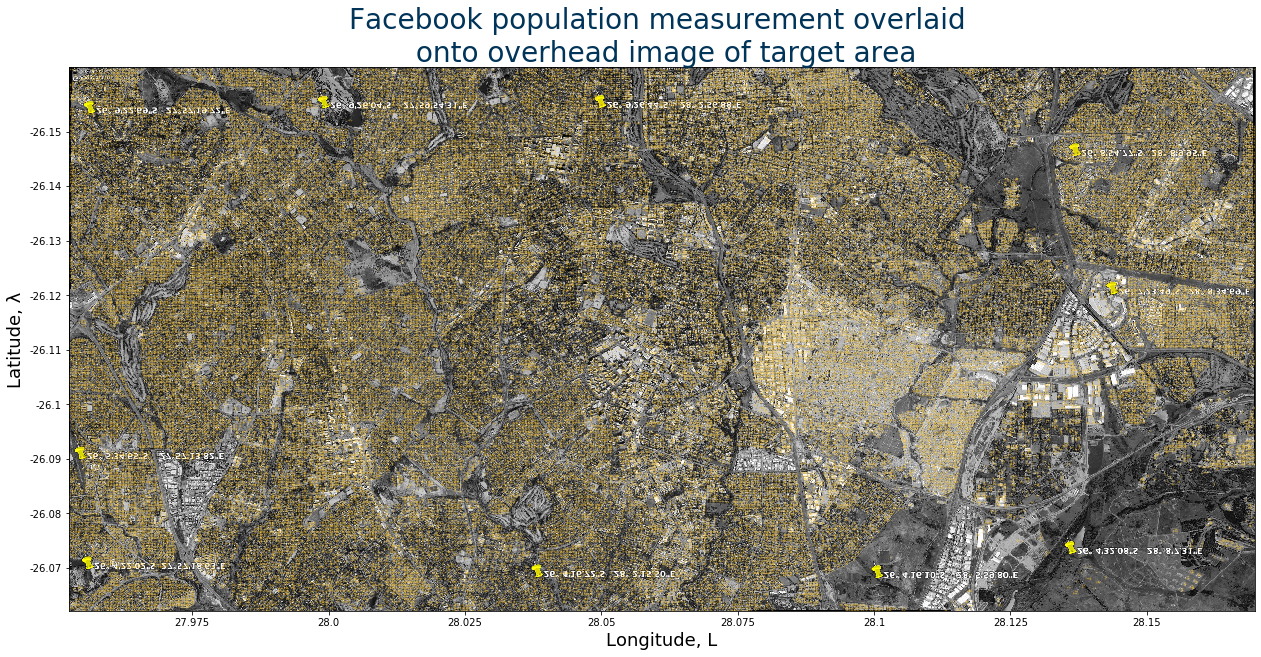

In [192]:
plt.figure(figsize = (22,10))
plt.imshow(np.stack([dataset.read(im_layer)
                      for im_layer in dataset.indexes],
                     axis = -1))
plt.xticks(ticks = 𝘓_ticks,
           labels = 𝘓_ticks_labels);
plt.yticks(ticks = 𝜆_ticks,
           labels = 𝜆_ticks_labels);
plt.xlim(left = 0, 
         right = dataset.width),
plt.ylim(bottom = 0,
         top = dataset.height);
plt.xlabel(xlabel = 'Longitude, L',
           fontsize = 18)
plt.ylabel(ylabel = 'Latitude, λ',
           fontsize = 18);
plt.scatter(jberg_pop_pix_raster['Longitude, L'],
            jberg_pop_pix_raster['Latitude, λ'],
            s = 1,
            color = '#ffc82d40');
plt.title(label = 'Facebook population measurement overlaid \n onto overhead image of target area',
          fontsize = 28,
          color = '#003459');